C:\Users\Sym\AppData\Local\Temp\ipykernel_21568\86406278.py:95: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  retornos_diarios = dados_ativos.pct_change()


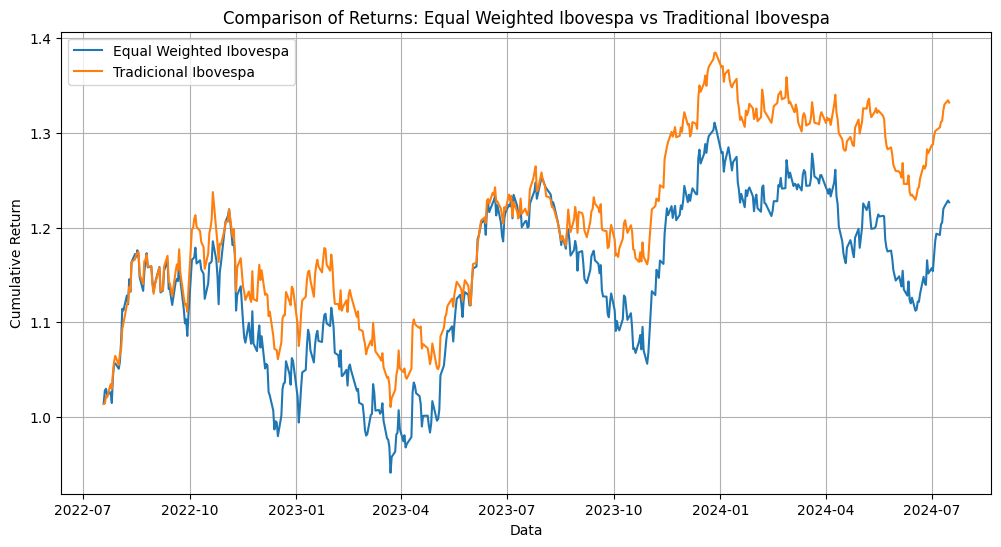


Contribuições por Ticker e Setor:
       Ticker  Contribuicao        Setor
0    ABEV3.SA     -0.337543   Industrial
1    RENT3.SA     -0.318427  Consumption
2    JBSS3.SA     -0.058251   Industrial
3    RDOR3.SA     -0.048172  Consumption
4    RADL3.SA      0.104832  Consumption
..        ...           ...          ...
199  EZTC3.SA     -0.199666   Industrial
200  NTCO3.SA     -0.155391   Industrial
201  BRKM5.SA     -0.649469   Industrial
202  VIVA3.SA     -0.040509   Industrial
203  ALPA4.SA     -0.708366   Industrial

[204 rows x 3 columns]

Contribuições Agregadas por Setor:
Setor
Consumption           -17.324119
Energy & Utility        3.720438
Financial               1.711982
Housing & Materials     0.889171
Industrial             -4.019965
Name: Contribuicao, dtype: float64


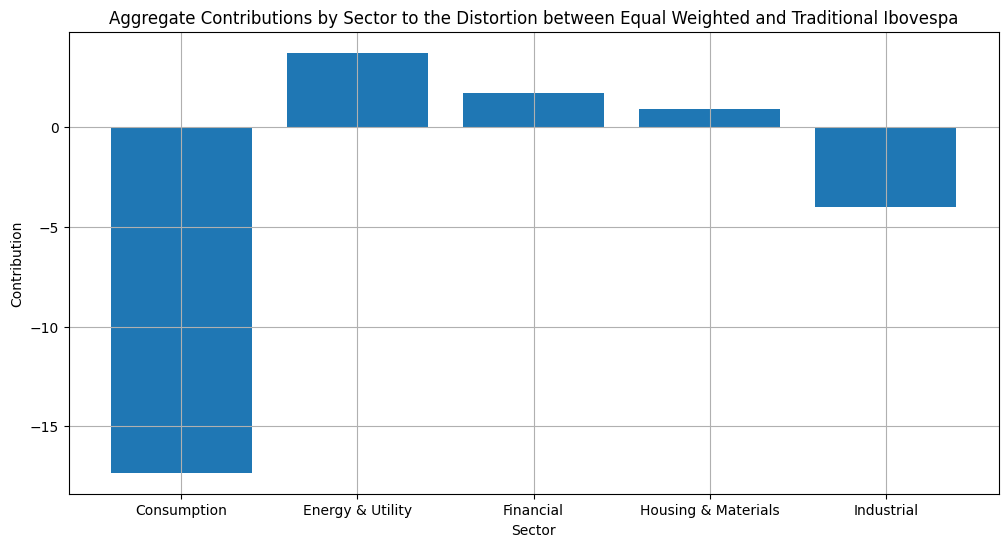

In [5]:
import cloudscraper
from bs4 import BeautifulSoup
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import logging

%matplotlib inline

# Disable yfinance logging
logging.getLogger('yfinance').setLevel(logging.WARNING)

# Function to get the tickers from a given Status Invest index URL
def obter_tickers_setorial(url):
    scraper = cloudscraper.create_scraper()
    response = scraper.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    tickers = []
    spans = soup.find_all('span', {'class': 'ticker'})
    for span in spans:
        ticker = span.text.strip() + '.SA'
        tickers.append(ticker)
    
    return tickers

# URLs for sector indices
urls_setoriais = {
    'Energy & Utility': [
        'https://statusinvest.com.br/indices/indice-de-energia-eletrica',
        'https://statusinvest.com.br/indices/indice-utilidade-publica'
    ],
    'Consumption': 'https://statusinvest.com.br/indices/indice-de-consumo',
    'Financial': 'https://statusinvest.com.br/indices/indice-financeiro',
    'Housing & Materials': [
        'https://statusinvest.com.br/indices/indice-imobiliario',
        'https://statusinvest.com.br/indices/indice-de-materiais-basicos'
    ],
    'Industrial': 'https://statusinvest.com.br/indices/indice-do-setor-industrial',
'Tech': [
        'https://statusinvest.com.br/acao/TOTS3',
        'https://statusinvest.com.br/acao/LWSA3'
    ]
}

# Manually add missing tickers
tickers_faltantes = {
    'Energy & Utility': [
        'PETR3.SA', 'PETR4.SA', 'RECV3.SA', 'TIMS3.SA', 'VBBR3.SA',
        'VIVT3.SA', 'RAIZ4.SA', 'UGPA3.SA', 'RAIL3.SA', 'CSAN3.SA',
        'PRIO3.SA', 'RRRP3.SA', 'AZUL4.SA', 'CCRO3.SA'
    ],
    'Financial': ['ITSA4.SA'],
    'Tech': ['TOTS3.SA', 'LWSA3.SA']
}

# Dictionary to hold tickers by sector
tickers_por_setor = {}

# Populate the tickers for each sector
for setor, urls in urls_setoriais.items():
    if isinstance(urls, list):
        tickers_setor = []
        for url in urls:
            tickers_setor.extend(obter_tickers_setorial(url))
        tickers_por_setor[setor] = tickers_setor
    else:
        tickers_por_setor[setor] = obter_tickers_setorial(urls)

# Function to get the list of Ibovespa stocks from Status Invest website
def obter_ativos_ibovespa():
    url = "https://statusinvest.com.br/indices/ibovespa"
    scraper = cloudscraper.create_scraper()
    response = scraper.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    tickers = []
    spans = soup.find_all('span', {'class': 'ticker'})
    for span in spans:
        ticker = span.text.strip() + '.SA'
        tickers.append(ticker)
    
    return tickers

# Select a period
periodo = "2y"

# Get the list of Ibovespa stocks
ativos_ibovespa = obter_ativos_ibovespa()

# Download stock data for Ibovespa stocks
dados_ativos = yf.download(ativos_ibovespa, period=periodo, progress=False)['Adj Close']

# Calculate daily returns
retornos_diarios = dados_ativos.pct_change()

def preencher_nan_com_media_linha(row):
    media_linha = row.mean()
    return row.fillna(media_linha)

retornos_diarios = retornos_diarios.apply(preencher_nan_com_media_linha, axis=1)

# Calculate the daily return of the equal-weighted index
retorno_equal_weighted = retornos_diarios.mean(axis=1)

# Get traditional Ibovespa index data
dados_ibovespa = yf.download('^BVSP', period=periodo, progress=False)['Adj Close']

# Calculate daily returns of the traditional Ibovespa index
retorno_ibovespa = dados_ibovespa.pct_change().dropna()

# Normalize the cumulative returns for plotting on the same graph
retorno_equal_weighted_acumulado = (1 + retorno_equal_weighted).cumprod()
retorno_ibovespa_acumulado = (1 + retorno_ibovespa).cumprod()

# Calculate cumulative returns for each individual stock
retorno_acumulado_ativos = (1 + retornos_diarios).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(retorno_equal_weighted_acumulado, label='Equal Weighted Ibovespa')
plt.plot(retorno_ibovespa_acumulado, label='Tradicional Ibovespa')
plt.title('Comparison of Returns: Equal Weighted Ibovespa vs Traditional Ibovespa')
plt.xlabel('Data')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.savefig('ibovespa_comparison.png')  # Save the figure as a PNG file
plt.show()

# Create a mapping of tickers to sectors
setores = {}
for setor, tickers in tickers_por_setor.items():
    for ticker in tickers:
        setores[ticker] = setor

# Filter returns to only include specified sectors
tickers_interesse = (
    tickers_por_setor['Consumption'] +
    tickers_por_setor['Energy & Utility'] +
    tickers_por_setor['Housing & Materials'] +
    tickers_por_setor['Financial'] +
    tickers_por_setor['Industrial'] +
    tickers_por_setor['Tech']
)

# Ensure tickers are present in the accumulated returns DataFrame
tickers_interesse_presentes = [ticker for ticker in tickers_interesse if ticker in retorno_acumulado_ativos.columns]
retorno_acumulado_interesse = retorno_acumulado_ativos[tickers_interesse_presentes]

# Calculate contributions for the selected tickers
contribuicoes = retorno_acumulado_interesse.iloc[-1] - retorno_equal_weighted_acumulado.iloc[-1]

# Create a DataFrame for contributions and sectors
df_contribuicoes = pd.DataFrame({
    'Ticker': contribuicoes.index,
    'Contribuicao': contribuicoes.values,
    'Setor': [setores.get(ticker, 'Unknown') for ticker in contribuicoes.index]
})

# Print contributions by ticker and sector
print("\nContribuições por Ticker e Setor:")
print(df_contribuicoes)

# Aggregate contributions by sector
contribuicoes_agregadas = df_contribuicoes.groupby('Setor')['Contribuicao'].sum()

# Print aggregated contributions by sector
print("\nContribuições Agregadas por Setor:")
print(contribuicoes_agregadas)

# Plot contributions by sector
plt.figure(figsize=(12, 6))
plt.bar(contribuicoes_agregadas.index, contribuicoes_agregadas.values)
plt.title('Aggregate Contributions by Sector to the Distortion between Equal Weighted and Traditional Ibovespa')
plt.xlabel('Sector')
plt.ylabel('Contribution')
plt.grid(True)
plt.savefig('sector_contributions.png')  # Save the figure as a PNG file
plt.show()